In [1]:
import sys
sys.executable

'C:\\Users\\Monoid\\anaconda3\\envs\\nn\\python.exe'

파이썬 환경 확인.
envs\\nn\\python.exe 으로 끝나기를 기대합니다

In [2]:
from preprocessing import readPreporcssedDataAll
import torch
from torch.utils.data import Dataset, DataLoader
from dataset import make_collate_fn, DatasetArray
from transformers import BertTokenizer
import torch.nn as nn
from read_data import TagIdConverter

In [3]:
TAGS_PATH = "eng_tags.json"
DATASET_PATH = "engpre"

변수 설정

In [4]:
tagIdConverter = TagIdConverter(TAGS_PATH)

In [5]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

Tokenizer 로딩

In [6]:
from transformers import BertModel

In [7]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


버트 로딩

In [8]:
class MyModel(nn.Module):
    def __init__(self,output_feat: int,bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.1)
        self.lin = nn.Linear(768,output_feat) #[batch_size,word_size,768] -> [batch_size,word_size,output_feat]
        self.softmax = nn.Softmax(2) #[batch_size,word_size,output_feat] -> [batch_size,word_size,output_feat]
        #0부터 시작해서 2 번째 차원에 softmax.

    def forward(self,**kargs):
        emb = self.bert(**kargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.lin(e)
        return w

In [9]:
model = MyModel(tagIdConverter.size,bert)
model.cuda()
bert.cuda()
print(model)

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

`tagIdConverter.size` 만큼의 종류가 있음

In [10]:
print("bert current device :",bert.device)

bert current device : cuda:0


In [11]:
device = torch.device("cuda")
device

device(type='cuda')

In [12]:
datasetTrain, datasetDev, datasetTest = readPreporcssedDataAll(DATASET_PATH)

In [15]:
my_collate_fn = make_collate_fn(tokenizer, tagIdConverter)

In [16]:
BATCH_SIZE = 4
train_loader = DataLoader(
        DatasetArray(datasetTrain),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)
dev_loader = DataLoader(
        DatasetArray(datasetDev),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)
test_loader = DataLoader(
        DatasetArray(datasetTest),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=my_collate_fn
)

In [18]:
from tqdm import tqdm

In [19]:
total_l = 0
total_o = 0

for item in tqdm(datasetTrain):
    entities = item["entity"]
    l = len(entities)
    o = sum(map(lambda x: 1 if x == "O" else 0,entities))
    total_l += l
    total_o += o

print(f"{total_o}/{total_l} = {total_o/total_l}")

100%|████████████████████████████████████████████████████████████████████████| 14041/14041 [00:00<00:00, 468033.78it/s]

212812/272841 = 0.7799854127495501


O token 이 77%를 차지함.

In [20]:
from torch.optim import AdamW

In [21]:
optimizer = AdamW(model.parameters(), lr=1.0e-5)
CELoss = nn.CrossEntropyLoss(ignore_index=tagIdConverter.pad_id)

In [22]:
from groupby_index import groupby_index

In [23]:
TRAIN_EPOCH = 5

result = []
iteration = 0

t = []

model.zero_grad()

for epoch in range(TRAIN_EPOCH):
    model.train()
    print(f"epoch {epoch} start:")
    with tqdm(train_loader, unit="minibatch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        
        for batch in groupby_index(tepoch,8):
            corrects = 0
            totals = 0
            losses = 0
            
            optimizer.zero_grad()
            for mini_i,mini_l in batch:
                batch_inputs = {k: v.cuda(device) for k, v in list(mini_i.items())}
                batch_labels = mini_l.cuda(device)
                attention_mask = batch_inputs["attention_mask"]
                
                output = model(**batch_inputs)
                loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))
            
                prediction = output.view(-1, output.size(-1)).argmax(dim=-1)
                corrects += ((prediction == batch_labels.view(-1)) * attention_mask.view(-1)).sum().item()
                totals += attention_mask.view(-1).sum().item()
                losses += loss.item()
                loss.backward()

            optimizer.step()
            accuracy = corrects / totals
            result.append({"iter":iteration,"loss":losses,"accuracy":accuracy})
            tepoch.set_postfix(loss=losses, accuracy= accuracy)
            iteration += 1

epoch 0 start:


Epoch 0: 100%|████████████████████████████████████| 3511/3511 [02:21<00:00, 24.82minibatch/s, accuracy=0.954, loss=1.2]


epoch 1 start:


Epoch 1: 100%|██████████████████████████████████| 3511/3511 [02:20<00:00, 24.97minibatch/s, accuracy=0.986, loss=0.288]


epoch 2 start:


Epoch 2: 100%|██████████████████████████████████| 3511/3511 [02:22<00:00, 24.65minibatch/s, accuracy=0.995, loss=0.192]


epoch 3 start:


Epoch 3: 100%|███████████████████████████████████| 3511/3511 [02:25<00:00, 24.20minibatch/s, accuracy=0.99, loss=0.313]


epoch 4 start:


Epoch 4: 100%|██████████████████████████████████| 3511/3511 [02:23<00:00, 24.47minibatch/s, accuracy=0.988, loss=0.345]


In [42]:
del batch_inputs
del batch_labels
del loss
del optimizer

In [43]:
torch.cuda.empty_cache()
print(f"gpu allocated : {torch.cuda.memory_allocated() // 1024**2} MB")
print(f"gpu reserved : {torch.cuda.memory_reserved() // 1024 ** 2}MB")

gpu allocated : 1355 MB
gpu reserved : 1470MB


In [24]:
%matplotlib inline

In [25]:
import numpy as np
import matplotlib.pyplot as plt

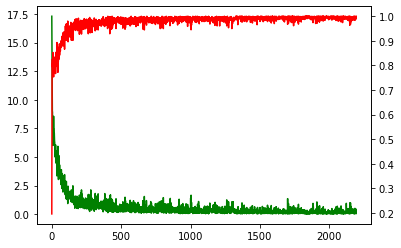

In [26]:
iters = [item["iter"] for item in result]
fig, ax1 = plt.subplots()
ax1.plot(iters,[item["loss"] for item in result],'g')
ax2 = ax1.twinx()
ax2.plot(iters,[item["accuracy"] for item in result],'r')
plt.xlabel("iter")
plt.show()

In [27]:
model.eval()
collect_list = []
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_i,batch_l in tepoch:
            batch_inputs = {k: v.cuda(device) for k, v in list(batch_i.items())}
            batch_labels = batch_l.cuda(device)
            output = model(**batch_inputs)
            loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))
            
            prediction = output.view(-1, output.size(-1)).argmax(dim=-1)
            correct = (prediction == batch_labels.view(-1)).sum().item()
            accuracy = correct / batch_inputs["attention_mask"].view(-1).sum()
            
            collect_list.append({"loss":loss.item(),"accuracy":accuracy, "batch_size":batch_labels.size(0),
                                "predict":output.argmax(dim=-1).cpu(),
                                "actual":batch_labels.cpu(),
                                "attention_mask":batch_inputs["attention_mask"].cpu()})

100%|█████████████████████████████████████████████████████████████████████████████| 864/864 [00:10<00:00, 83.69batch/s]


In [31]:
def getConfusionMatrix(predict,actual,attention_mask):
    ret = torch.zeros((tagIdConverter.size,tagIdConverter.size),dtype=torch.long)
    for i,(p_s,a_s) in enumerate(zip(predict,actual)):
        for j,(p,a) in enumerate(zip(p_s,a_s)):
            ret[p,a] += attention_mask[i,j]
    return ret

In [33]:
total_loss = 0
total_accuracy = 0
total_size = 0
confusion = torch.zeros((tagIdConverter.size,tagIdConverter.size),dtype=torch.long)

for item in collect_list:
    batch_size = item["batch_size"]
    total_loss += batch_size * item["loss"]
    total_accuracy += batch_size * item["accuracy"]
    total_size += batch_size
    confusion += getConfusionMatrix(item["predict"],item["actual"],item["attention_mask"])
print(f"""average_loss : {total_loss/total_size}, average_accuracy : {total_accuracy/total_size}, size :{total_size}""")

average_loss : 0.13179491325355058, average_accuracy : 0.9739284515380859, size :3453


In [34]:
confusion

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,  1566,    19,    78,    19,     1,     3,     1,     0,    22],
        [    0,    30,   599,    53,     3,     1,    11,     1,     1,    76],
        [    0,    48,    32,  1479,    21,     2,     1,     3,     0,    53],
        [    0,     7,    14,    17,  1557,     0,     6,     1,     2,    27],
        [    0,     1,     0,     0,     0,  1510,    47,   101,    26,    45],
        [    0,     2,     8,     0,     0,    39,   583,    54,     4,   298],
        [    0,     7,     2,     9,     0,    39,    63,  2560,    32,   122],
        [    0,     0,     0,     1,     8,    11,    38,    29,  3355,    33],
        [    0,     7,    28,    24,     9,    25,    86,    45,    15, 55141]])

In [35]:
confusion = confusion[0:(tagIdConverter.size - 1)][0:(tagIdConverter.size - 1)]

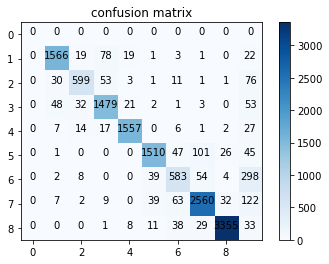

In [36]:
import itertools

plt.title("confusion matrix")
plt.imshow(confusion,cmap='Blues')

plt.colorbar()
for i,j in itertools.product(range(confusion.shape[0]),range(confusion.shape[1])):
    plt.text(j,i,"{:}".format(confusion[i,j]),horizontalalignment="center",color="black" if i == j else "black")
plt.show()

In [37]:
def getF1Score(confusion,c):
    TP = confusion[c,c]
    FP = confusion[c].sum() - TP
    FN = confusion[:,c].sum() - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1Score = (2*precision*recall)/(precision + recall)
    return f1Score

In [39]:
for i in range(tagIdConverter.size - 1):
    f1 = getF1Score(confusion,i)
    print(f"class {i} f1 score : {f1}")

class 0 f1 score : nan
class 1 f1 score : 0.9293768405914307
class 2 f1 score : 0.8267770409584045
class 3 f1 score : 0.9029303789138794
class 4 f1 score : 0.9614078402519226
class 5 f1 score : 0.9060906171798706
class 6 f1 score : 0.6701149344444275
class 7 f1 score : 0.9169055223464966
class 8 f1 score : 0.9731689691543579


In [40]:
import collections

In [41]:
counter = collections.Counter()
total_l = 0

for item in tqdm(itertools.chain(datasetTrain,datasetDev,datasetTest)):
    entities = item["entity"]
    for entity in entities:
        counter[entity] += 1
    total_l += len(entities)
print(f"{'token':<12}\t{'count':>12} {'frequency%':>12}")
for token,count in counter.most_common():
    tid = tagIdConverter.convert_tokens_to_ids([token])[0]
    print(f"{f'{token}({tid})':<12}\t{count:>12}{count*100/total_l:>12.3f}%")

20744it [00:00, 170034.81it/s]

token       	       count   frequency%
O(9)        	      314867      77.841%
I-PER(8)    	       21118       5.221%
I-ORG(7)    	       16329       4.037%
I-LOC(5)    	       10922       2.700%
B-LOC(1)    	       10645       2.632%
B-PER(4)    	       10059       2.487%
B-ORG(3)    	        9322       2.305%
I-MISC(6)   	        6176       1.527%
B-MISC(2)   	        5062       1.251%
